# Poiseuille Channel (regularized)

The simulation of a periodic Poiseuille flow is used for the validation of regularized no-slip boundary condition, which works directly with macroscopic variables and is necessary for increasing numerical stability and use of moment based lattice-Boltzmann method.
The external force density term still represents the pressure gradient $F_{x}=-\mathrm{d}p/\mathrm{d}x$, regularized no-slip BC is implemented at $y=0$ and $y=H$, and periodicity is considered in the remaining boundaries.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/02_poiseuille_channel_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

The only change from the periodic case, is that it's now using regularized halfway bounce back (HWBB) as BC for the wall, instead of plain HWBB.

In [2]:
sim_cfgs_use = [
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if name == "regularizedPeriodicPoiseuilleChannel"
]

[sim_cfg.full_name for sim_cfg in sim_cfgs_use]

['regularizedPeriodicPoiseuilleChannel:000',
 'regularizedPeriodicPoiseuilleChannel:001',
 'regularizedPeriodicPoiseuilleChannel:002',
 'regularizedPeriodicPoiseuilleChannel:003']

Extract data from multiblock data from output file of macrs export

In [3]:
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
from tests.validation.notebooks import common

extracted_data = {}
array_to_extract = "ux"

for sim_cfg in sim_cfgs_use:
    export_instantaneous_cfg = sim_cfg.output.instantaneous
    macr_export = export_instantaneous_cfg["default"]
    time_step = macr_export.time_steps(sim_cfg.n_steps)[-1]
    reader = macr_export.read_vtm_export(time_step)

    p1 = [sim_cfg.domain.domain_size.x / 2, 0, 0]
    p2 = [sim_cfg.domain.domain_size.x / 2, sim_cfg.domain.domain_size.y, 0]
    line = common.create_line(p1, p2, sim_cfg.domain.domain_size.y - 1)

    # Get the points from the vtkLineSource
    polyData = line.GetOutput()
    points = polyData.GetPoints()

    pos = np.linspace(p1, p2, sim_cfg.domain.domain_size.y)

    probe_filter = common.probe_over_line(line, reader.GetOutput())

    probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(array_to_extract))
    extracted_data[(sim_cfg.sim_id, sim_cfg.name)] = {
        "pos": np.array(pos),
        "data": probed_data,
    }

extracted_data.keys()

dict_keys([(0, 'regularizedPeriodicPoiseuilleChannel'), (1, 'regularizedPeriodicPoiseuilleChannel'), (2, 'regularizedPeriodicPoiseuilleChannel'), (3, 'regularizedPeriodicPoiseuilleChannel')])

## Results

The velocity profile at the end of simulation is compared with the steady state analytical solution below:

Processing functions for Poiseuille Flow case

In [4]:
from typing import Callable


def get_poiseuille_analytical_func() -> Callable:
    """Poiseuille analytical velocity function

    Returns:
        Callable: Analytical velocity function
    """
    return lambda pos: 6 * (pos - pos**2)


def plot_analytical_poiseuille_vels(ax):
    x = np.arange(0, 1.01, 0.01)
    analytical_func = get_poiseuille_analytical_func()
    analytical_data = analytical_func(x)
    ax.plot(x, analytical_data, "--k", label="Analytical")

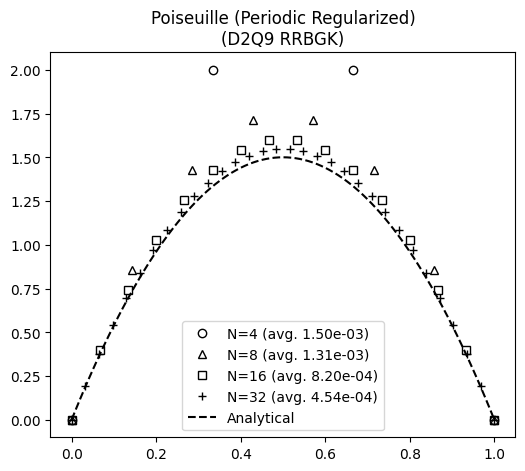

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

style_num = ["o", "^", "s", "+", "x"]

for sim_cfg, mkr_style in zip(sim_cfgs_use, style_num):
    num_data = extracted_data[(sim_cfg.sim_id, sim_cfg.name)]
    num_avg_vel = np.average(num_data["data"])
    position_vector = (num_data["pos"][:, 1]) / (sim_cfg.domain.domain_size.y)
    ax.plot(
        position_vector,
        num_data["data"] / num_avg_vel,
        mkr_style,
        label=f"N={sim_cfg.domain.domain_size.x} (avg. {num_avg_vel:.2e})",
        fillstyle="none",
        c="k",
    )

sim_cfg_ref = sim_cfgs_use[0]
plot_analytical_poiseuille_vels(ax)
ax.set_title(
    f"Poiseuille (Periodic Regularized)\n({sim_cfg_ref.models.LBM.vel_set} {sim_cfg_ref.models.LBM.coll_oper})"
)
ax.legend()
plt.show(fig)

The results show that the flow evolution equation from LBM converges to steady analytical solution.


The second order error decay under grid refinement for the present case is also verified:


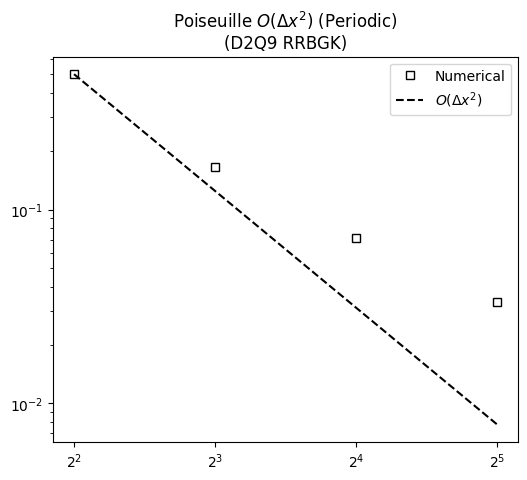

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)

analytical_error_prof: list[float] = []
numerical_error_prof: list[float] = []
N_list: list[int] = []

analytical_func = get_poiseuille_analytical_func()

for sim_cfg in sim_cfgs_use:
    num_data = extracted_data[(sim_cfg.sim_id, sim_cfg.name)]
    num_avg_vel = np.average(num_data["data"])
    num_pos = num_data["pos"][:, 1] / sim_cfg.domain.domain_size.y
    num_profile = num_data["data"] / num_avg_vel

    num_o2_error = common.get_o2_error(num_pos, num_profile, analytical_func)
    analyical_error = (
        num_o2_error if len(analytical_error_prof) == 0 else analytical_error_prof[-1] / 4
    )

    analytical_error_prof.append(analyical_error)
    numerical_error_prof.append(num_o2_error)
    N_list.append(sim_cfg.domain.domain_size.y)

ax.plot(N_list, numerical_error_prof, "sk", fillstyle="none", label="Numerical")
ax.plot(N_list, analytical_error_prof, "--k", label=r"$O(\Delta x^2)$")

ax.set_yscale("log")
ax.set_xscale("log", base=2)
ax.set_title(
    r"Poiseuille $O(\Delta x^2)$ (Periodic)"
    + f"\n({sim_cfg.models.LBM.vel_set} {sim_cfg.models.LBM.coll_oper})"
)
ax.legend()
plt.show(fig)

It's possible to check that the second order error does not stands for regularized HWBB.

## Version

In [7]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 03afae00d1166dcb73bd88413bb3cfda7b6c686c


## Configuration

In [8]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicPoiseuilleChannel
    save_path: ./tests/validation/results/02_poiseuille_channel_flow/periodic

    n_steps: !unroll [250, 1000, 4000, 16000]

    report:
      frequency: 1000

    domain:
      domain_size:
        x: !unroll [4, 8, 16, 32]
        y: !unroll [4, 8, 16, 32]
      block_size: !unroll [4, 8, 8, 8]

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 0 }, macrs: [rho, u] }
      statistics:
        interval: { frequency: 0 }

    models:
      precision:
        default: single

      LBM:
        tau: 0.9
        vel_set: D2Q9
        coll_oper: RRBGK
        F:
          # FX is divided by 8
          x: !unroll [4.0e-4, 5.0e-5, 6.25e-6, 7.8125e-07]
          y: 0

      multiblock:
        overlap_F2C: 1

      engine:
        name: CUDA

      BC:
        periodic_dims: [true, false]
        BC_map:
          - pos: N
            BC: HWBB
            wall_normal: N

          - pos: S
            BC: HWBB
            wall_normal: S

  - name: regularizedPeriodicPoiseuilleChannel
    parent: periodicPoiseuilleChannel

    models:
      LBM:
        coll_oper: RRBGK

      BC:
        periodic_dims: [true, false]
        BC_map:
          - pos: N
            BC: RegularizedHWBB
            wall_normal: N

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S

  - name: velocityNeumannPoiseuilleChannel
    parent: periodicPoiseuilleChannel

    save_path: ./tests/validation/results/02_poiseuille_channel_flow/velocity_neumann

    report: { frequency: 1000 }

    n_steps: 64000
    domain:
      domain_size:
        x: 256
        y: 32
      block_size: 8

    data:
      instantaneous:
        default: { interval: { frequency: 16000 }, macrs: [rho, u] }

    models:
      LBM: !not-inherit
        tau: 0.9
        vel_set: D2Q9
        coll_oper: RRBGK

      BC:
        periodic_dims: [false, false]
        BC_map:
          - pos: W
            BC: UniformFlow
            wall_normal: W
            rho: 1.0
            ux: 0.05
            uy: 0
            uz: 0
            order: 1

          - pos: E
            BC: RegularizedNeumannOutlet
            rho: 1.0
            wall_normal: E
            order: 1

          - pos: N
            BC: RegularizedHWBB
            wall_normal: N
            order: 0

          - pos: S
            BC: RegularizedHWBB
            wall_normal: S
            order: 0

  - name: velocityNeumannPoiseuilleChannelMultilevel
    parent: periodicPoiseuilleChannel

    save_path: ./tests/validation/results/02_poiseuille_channel_flow/multilevel

    n_steps: 64000

    domain:
      domain_size:
        x: 96
        y: 24
      block_size: 8
      refinement:
        static:
          default:
            volumes_refine:
              - { start: [0, 0], end: [8, 8], lvl: 1, is_abs: true }
              - { start: [0, 16], end: [8, 24], lvl: 1, is_abs: true }
              - { start: [8, 8], end: [24, 16], lvl: 1, is_abs: true }
              - { start: [16, 0], end: [32, 8], lvl: 1, is_abs: true }
              - { start: [24, 16], end: [48, 24], lvl: 1, is_abs: true }
              - { start: [40, 8], end: [48, 16], lvl: 1, is_abs: true }
              - { start: [56, 0], end: [72, 8], lvl: 1, is_abs: true }
              - { start: [80, 8], end: [88, 16], lvl: 1, is_abs: true }
              - { start: [88, 16], end: [96, 24], lvl: 1, is_abs: true }

    data:
      divergence: { frequency: 50 }
      instantaneous:
        default: { interval: { frequency: 12000 }, macrs: [rho, u, S] }

    models:
      precision:
        default: single

      LBM: !not-inherit
        tau: 0.8
        vel_set: D2Q9
        coll_oper: RRBGK

      engine:
        name: CUDA

      BC:
        periodic_dims: [false, false, true]
        BC_map:
          - pos: W
            BC: UniformFlow
            rho: 1.0
            ux: 0.05
            uy: 0
            uz: 0
       